# Find distribution of local maxima in a Gaussian Random Field

Description

## Simulate random fields (without activation) and extract local maxima

In [2]:
% matplotlib inline
import os
import numpy as np
import nibabel as nib
from nipy.labs.utils.simul_multisubject_fmri_dataset import surrogate_3d_dataset
import nipy.algorithms.statistics.rft as rft
from __future__ import print_function, division
import math
import matplotlib.pyplot as plt
import palettable.colorbrewer as cb
from nipype.interfaces import fsl
import pandas as pd
import nipy.algorithms.statistics.intvol as intvol
from matplotlib import colors

#### Simulate very large RF

In [2]:
smooth_FWHM = 3
smooth_sd = smooth_FWHM/(2*math.sqrt(2*math.log(2)))
data = surrogate_3d_dataset(n_subj=1,sk=smooth_sd,shape=(500,500,500),noise_level=1)

#### Show part of the RF (20x20x1)

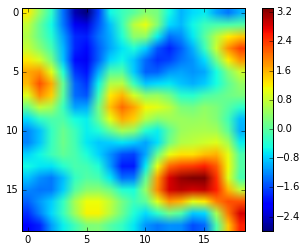

In [3]:
plt.figure(figsize=(6,4))
plt.imshow(data[1:20,1:20,1])
plt.colorbar()
plt.show()

#### Save RF

In [4]:
minimum = data.min()
newdata = data - minimum #little trick because fsl.model.Cluster ignores negative values
img=nib.Nifti1Image(newdata,np.eye(4))
img.to_filename("files/RF.nii.gz")

#### Run fsl cluster to extract local maxima

In [5]:
cl=fsl.model.Cluster()
cl.inputs.threshold = 0
cl.inputs.in_file="files/RF.nii.gz"
cl.inputs.out_localmax_txt_file="files/locmax.txt"
cl.inputs.num_maxima=1000000
cl.inputs.connectivity=26
cl.inputs.terminal_output='none'
cl.run()

#### Read and print top of file with peaks 

In [6]:
peaks = pd.read_csv("files/locmax.txt",sep="\t").drop('Unnamed: 5',1)
peaks.Value = peaks.Value + minimum
peaks[:5]

,Cluster Index,Value,x,y,z
0,1,6.259572,71,0,0
1,1,6.059572,353,394,0
2,1,5.859572,30,153,0
3,1,5.859572,148,20,0
4,1,5.859572,0,36,240


#### Total number of peaks

In [7]:
len(peaks)

614710

## Look at distribution of local maxima

#### Plot histogram of peak heights 

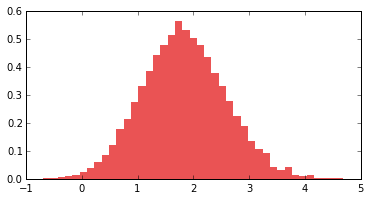

In [12]:
col=cb.qualitative.Set1_8.mpl_colors
plt.figure(figsize=(6,3))
ax=plt.subplot(111)
ax.hist(peaks.Value,60,normed=1,facecolor=col[0],alpha=0.75,lw=0)
ax.set_xlim([-1,5])
plt.show()

## Distribution of local maxima above u (Cheng & Schwartzman, 2015)

#### Function for pdf of peaks given a certain threshold

In [13]:
def nulprobdens(exc,peaks):
	v = exc
	u = peaks - v
	f0 = (2+(u+v)**2)*(u+v)*np.exp(-(u+v)**2/2)/(v**2*np.exp(-v**2/2))
	return f0

#### Compute density function over a range with different excursion thresholds 

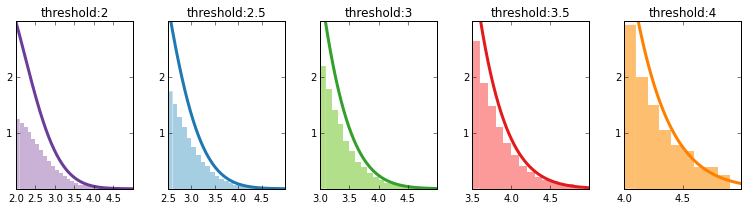

In [15]:
fig,axs=plt.subplots(1,5,figsize=(13,3))
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs=axs.ravel()
thresholds=[2,2.5,3,3.5,4]
bins=np.arange(2,5,0.5)
x=np.arange(2,10,0.0001)

twocol=cb.qualitative.Paired_10.mpl_colors
for i in range(5):
    thr=thresholds[i]
    axs[i].hist(peaks.Value[peaks.Value>thr],lw=0,facecolor=twocol[i*2-2],normed=True,bins=np.arange(thr,5,0.1))
    axs[i].set_xlim([thr,5])
    axs[i].set_ylim([0,3])
    xn = x[x>thr]
    yn = nulprobdens(thr,xn)    
    axs[i].plot(xn,yn,color=twocol[i*2-1],lw=3)
    axs[i].set_title("threshold:"+str(thr))
    axs[i].set_xticks(np.arange(thr,5,0.5))
    axs[i].set_yticks([1,2])
plt.show()

In this figure, we see the observed tail distribution of the local maxima (light colored) in our simulated data.  The thick line represents the theoretical distribution of the local maxima above a certain threshold. **WOW!** It's only a good approximation for **very** high thresholds.

## How does this relate to the Euler Characteristic Density?

#### Let's first look at the masks that result from our random field with certain thresholds

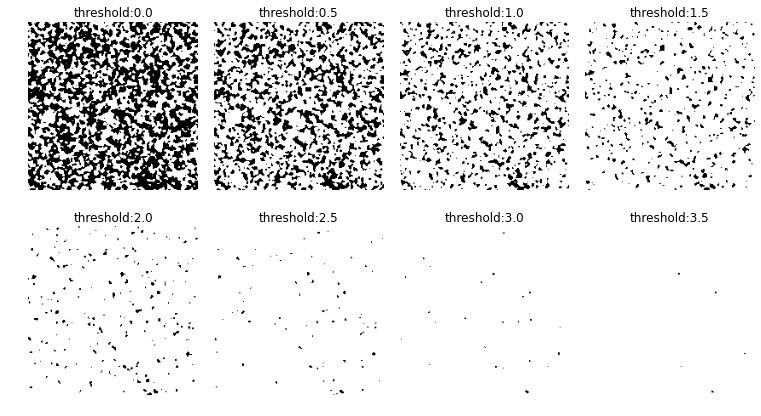

In [16]:
fig,axs=plt.subplots(2,4,figsize=(13,7))
fig.subplots_adjust(hspace = .1, wspace=0.1)
axs=axs.ravel()
thresholds=np.arange(0,4,0.5)
cmap = colors.ListedColormap(['white', 'black'])
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

for t in range(len(thresholds)):
    mask = np.zeros(shape=data.shape,dtype=np.intp)
    mask[data>thresholds[t]]=1
    axs[t].imshow(mask[1:200,1:200,20],cmap=cmap,norm=norm)
    axs[t].set_title("threshold:"+str(thresholds[t]))
    axs[t].patch.set_visible(False)
    axs[t].axis('off')


#### Now we'll look at the number of peaks and the Euler Characteristic against the threshold.

In [17]:
EulerDens = []
EulerDensInv = []
urange = np.arange(-4,4,0.3)
for t in urange:
    mask = np.zeros(shape=data.shape,dtype=np.intp)
    mask[data>t]=1
    EulerDens.append(intvol.EC3d(mask))
    mask2 = 1-mask
    EulerDensInv.append(intvol.EC3d(mask2))


In [19]:
sumpeak = []
for t in urange:
    sumpeak.append(sum(peaks.Value>t))


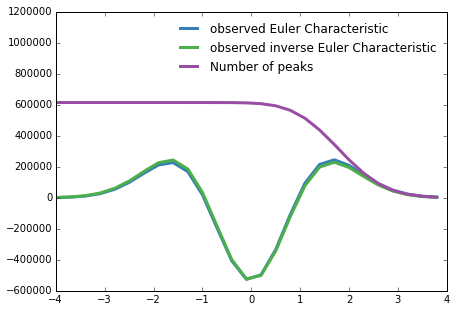

In [54]:
plt.figure(figsize=(7,5))
plt.plot(urange,EulerDens,color=col[1],lw=3,label="observed Euler Characteristic")
plt.plot(urange,EulerDensInv,color=col[2],lw=3,label="observed inverse Euler Characteristic")
plt.plot(urange,sumpeak,color=col[3],lw=3,label="Number of peaks")
plt.legend(loc="upper right",frameon=False)
plt.ylim([-600000,1200000])
plt.show()

# See distribution for different smoothness

At a certain point (around 2.5), there start to exist holes in the mask.  Therefore the Euler Characteristic cannot be used anymore to predict the number of peaks.  Can we use the smoothness?

In [4]:
smoothnesses = range(0,11)
minima = []
for sm in range(11):
    smooth_FWHM = smoothnesses[sm]
    smooth_sd = smooth_FWHM/(2*math.sqrt(2*math.log(2)))
    data = surrogate_3d_dataset(n_subj=1,sk=smooth_sd,shape=(500,500,500),noise_level=1)
    minimum = data.min()
    newdata = data - minimum #little trick because fsl.model.Cluster ignores negative values
    minima.append(minimum)
    img=nib.Nifti1Image(newdata,np.eye(4))
    img.to_filename(os.path.join("files/RF_"+str(sm)+".nii.gz"))
    cl=fsl.model.Cluster()
    cl.inputs.threshold = 0
    cl.inputs.in_file=os.path.join("files/RF_"+str(sm)+".nii.gz")
    cl.inputs.out_localmax_txt_file=os.path.join("files/locmax_"+str(sm)+".txt")
    cl.inputs.num_maxima=1000000
    cl.inputs.connectivity=26
    cl.inputs.terminal_output='none'
    cl.run()


In [3]:
all = []
for sm in range(11):
    peaks = pd.read_csv(os.path.join("files/locmax_"+str(sm)+".txt"),sep="\t").drop('Unnamed: 5',1).Value
    peaks = peaks + minima[sm]
    all.append(peaks)


NameError: name 'minima' is not defined

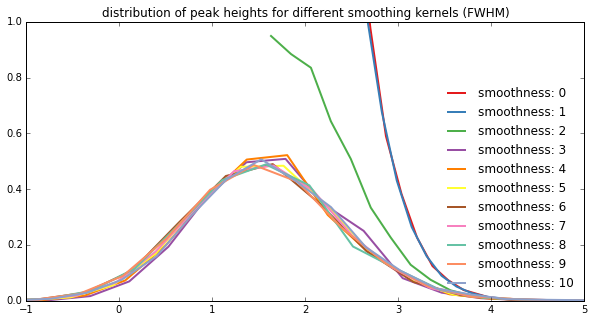

In [50]:
col=cb.qualitative.Set1_8.mpl_colors+cb.qualitative.Set2_8.mpl_colors
plt.figure(figsize=(10,5))
ax=plt.subplot(111)
for sm in range(11):
    values, base = np.histogram(all[sm],20,normed=1)
    ax.plot(base[:-1],values,label="smoothness: "+str(sm),color=col[sm],lw=2)
ax.set_xlim([-1,5])
ax.set_ylim([0,1])
ax.legend(loc="lower right",frameon=False)
ax.set_title("distribution of peak heights for different smoothing kernels (FWHM)")
plt.show()


As expected, from a certain smoothness (3 x voxel size), the distribution remains the same.

In [47]:
nop = []
for sm in range(11):
    nop.append(len(all[sm]))


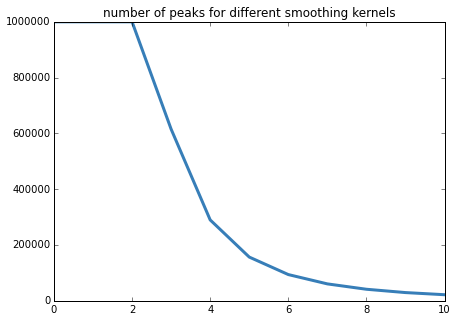

In [57]:
plt.figure(figsize=(7,5))
plt.plot(smoothnesses,nop,color=col[1],lw=3)
plt.title("number of peaks for different smoothing kernels")
plt.show()